In [1]:
#Program: polygonStockAnalysisApiProject
#Purpose: The goal of this project is to learn how to use an API while also getting some experience with financial data.
#Author: Brett Musselman
#Date: 9-10 June 2023

In [2]:
#Install libraries
import json
import requests as req
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
#from polygon import RESTClient

In [3]:
#API info
#Research: https://realpython.com/api-integration-in-python/
apiKey = 'PTwaFYew2jDkwjTYDHdRn9IGYxbRtWGv'
apiUrl = 'https://api.polygon.io/v2/aggs/ticker/AAPL/range/1/day/2023-01-09/2023-01-09?'

In [4]:
#Connect to API
response = req.get(f'{apiUrl}apiKey={apiKey}')
print(response)

<Response [200]>


In [5]:
#Check connection
#Source: https://www.projectpro.io/recipes/connect-api-endpoint-and-query-data-python
if response.status_code == 200:
    print("Succesful connection with API.")
    print('-------------------------------')
    data = response.json()
    print(data)
elif response.status_code == 404:
    print("Unable to reach URL.")
else:
    print("Unable to connect API or retrieve data.")

Succesful connection with API.
-------------------------------
{'ticker': 'AAPL', 'queryCount': 1, 'resultsCount': 1, 'adjusted': True, 'results': [{'v': 70790813.0, 'vw': 131.6292, 'o': 130.465, 'c': 130.15, 'h': 133.41, 'l': 129.89, 't': 1673240400000, 'n': 645365}], 'status': 'OK', 'request_id': '92fec98aee2314e7e6fb1381a3908a22', 'count': 1}


In [6]:
#Now that I know how to call an API using the url and key, I am going to pull stocks for JPMorgan to stay on theme
#Specific API call for JPMorgan stock
#Research: https://www.geeksforgeeks.org/write-a-dictionary-to-a-file-in-python/
stocksTicker = 'JPM'
multiplier = '1'
timespan = 'day'
fromV = '2013-06-09' #Data from 2013 (ten year range)
to = '2023-06-0' #Current date
urlForAggregates = f'/v2/aggs/ticker/{stocksTicker}/range/{multiplier}/{timespan}/{fromV}/{to}'

#Other changes from original API call
basicApiUrl = 'https://api.polygon.io'
apiUrlExtension = '9?adjusted=true&sort=asc&limit=120&apiKey='

jpmResponse = req.get(f'{basicApiUrl}{urlForAggregates}{apiUrlExtension}{apiKey}')

jpmJson = jpmResponse.json()

resultsFromFirstCall = jpmJson['results']

resultsList = resultsFromFirstCall

#Sentinel variable to use for loop
anotherCall = True

#There is a next url, so I have to iterate through each response and call every next url, I will add everything to a file
with open ('jpmAggregateData.txt', 'a') as file:
    file.truncate(0)

    #Keep calling API and adding to file unless the next_url does not exist in dict
    while anotherCall == True:
        #Retrieve value to see if next_url key exists in dict
        nextUrlExist = jpmJson.get('next_url')
            
        if nextUrlExist is not None:
            nextUrl = jpmJson['next_url']
            jpmResponse = req.get(f'{nextUrl}&apikey={apiKey}')
            jpmJson = dict(jpmResponse.json())
            jpmResults = jpmJson['results']
            for listItem in jpmResults:
                resultsList.append(listItem)
                file.write(str(listItem))
        else:
            anotherCall = False

KeyError: 'results'

In [9]:
#Now I have the data for the stock in JSON file, I will create dataframe
#Documentation: https://polygon.io/docs/stocks/get_v2_aggs_ticker__stocksticker__range__multiplier___timespan___from___to
#Research: https://pynative.com/python-parse-multiple-json-objects-from-file/

#Make json struct
fullJson = json.loads(json.dumps(resultsList))

#Pull specifically the results section and make dataframe
df1 = pd.DataFrame.from_records(fullJson)

print(df1.head())

            v        vw       o       c        h        l              t  \
0  12249868.0  161.7300  164.36  160.40  165.240  160.310  1623297600000   
1  13788752.0  159.9664  160.43  160.29  161.199  159.060  1623384000000   
2  20075243.0  157.9164  160.15  157.57  160.330  156.655  1623643200000   
3  24759055.0  155.1092  156.70  155.18  156.920  154.130  1623729600000   
4  25536607.0  155.3105  154.73  156.27  157.620  153.110  1623816000000   

        n  
0  122341  
1  128221  
2  185210  
3  216613  
4  232039  


In [18]:
#Rename columns
df1.rename(columns={'v': 'TradingVolume', 'vw': 'VolumeWeightedAveragePrice', 'o': 'OpenPrice', 'c': 'ClosePrice', 'h': 'HighestPrice', 'l': 'LowestPrice', 't': 'Time', 'n': 'NumberOfTransactions'}, inplace=True)
df1.name = 'JPM Stock Aggregates'
df1.to_csv('df1.csv', index=False)

In [11]:
#I believe that the API access caps me out at 504 days
#Dataframe is working, csv is created, now it is time to run through EDA
#Correlation matrix
#Source: Kaggle
def plotCorrelationMatrix(df, graphWidth):
    filename = 'JPM Stock Aggregates' #hardcoded because issue
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [13]:
#Scatter matrix with histograms on diagonal
#Source: Kaggle
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist') #Changed to histograms because I prefer over kde
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [14]:
#Description text (personal code)
with open('describe_jpm_stock.txt', 'a') as describeFile:
    describeFile.truncate(0)
    columnsList = list(df1.columns)
    for column in columnsList:
        describeColumn = df1[column].describe()
        stringColumn = str(describeColumn)
        describeFile.write(stringColumn)

C:\Users\brett\AppData\Local\Temp\ipykernel_22104\915701173.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns') # drop columns with NaN


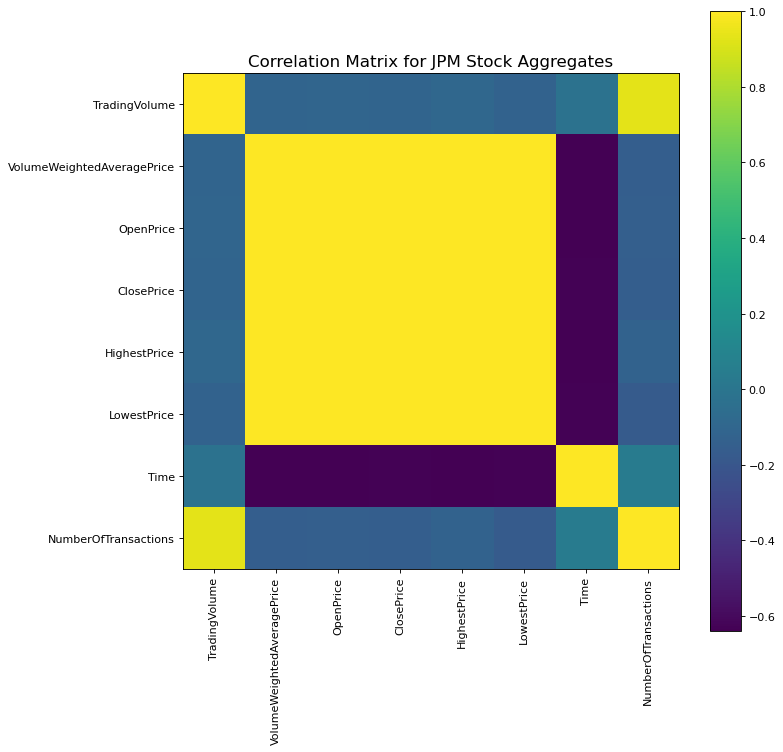

C:\Users\brett\AppData\Local\Temp\ipykernel_22104\244676979.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.dropna will be keyword-only.
  df = df.dropna('columns')


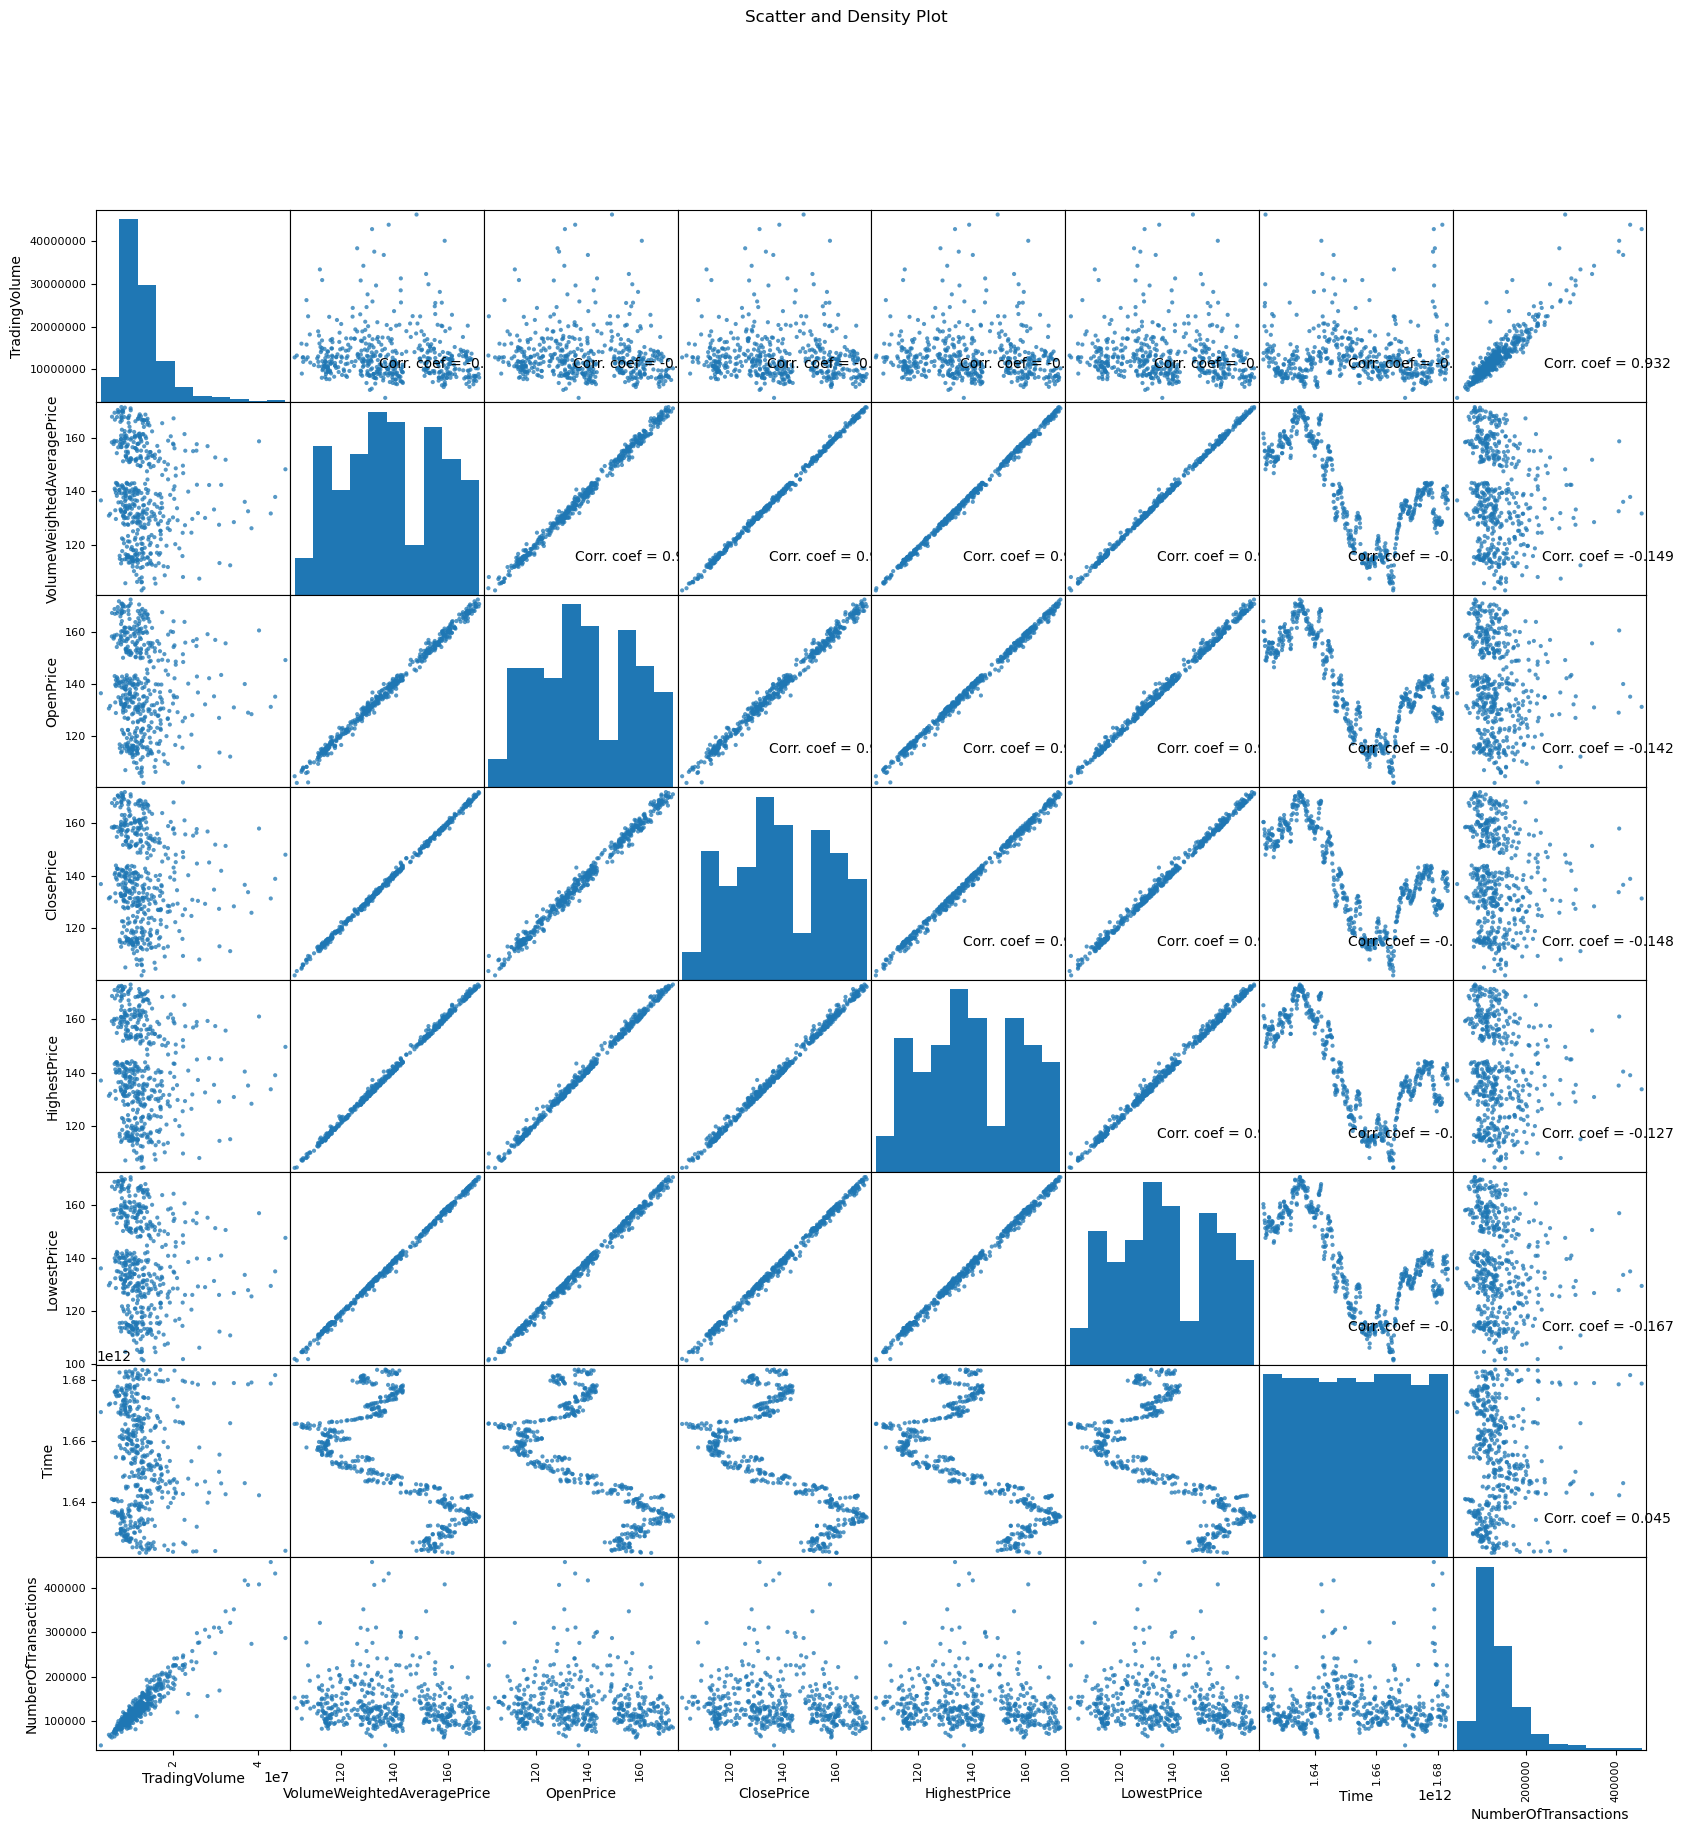

In [15]:
#Call correlation matrix and scatter matrix
plotCorrelationMatrix(df1, 10)
plotScatterMatrix(df1,20,10)

In [19]:
#From this EDA, we see the only phenomenon to study is the Time Series Forecast
#Import scikit learn and loosely follow this: https://medium.com/@abiolafadeyi10/time-series-forecasting-predicting-stock-prices-using-python-87df91e1fe89

import datetime
import math

df1['Time'] = pd.to_datetime(df1['Time'])
df1.set_index('Time', inplace=True)

print(df1['Time'].head())

#Issues with datetime conversion

KeyError: 'Time'

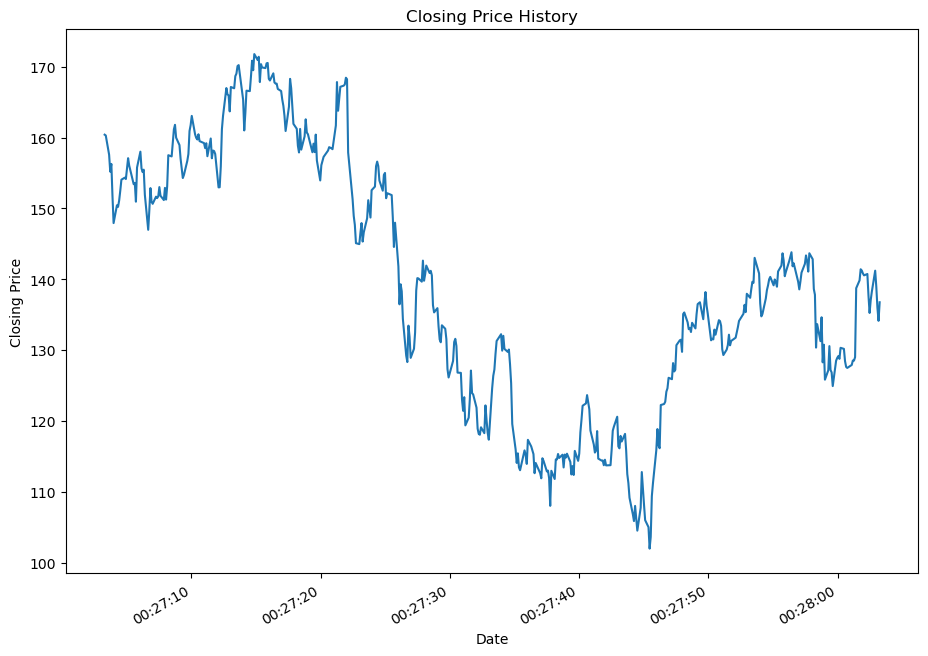

In [20]:
#Plot Close Price Against Time
plt.figure(figsize=(11,8))
df1['ClosePrice'].plot()
plt.title('Closing Price History')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.show()

<Figure size 1600x800 with 0 Axes>

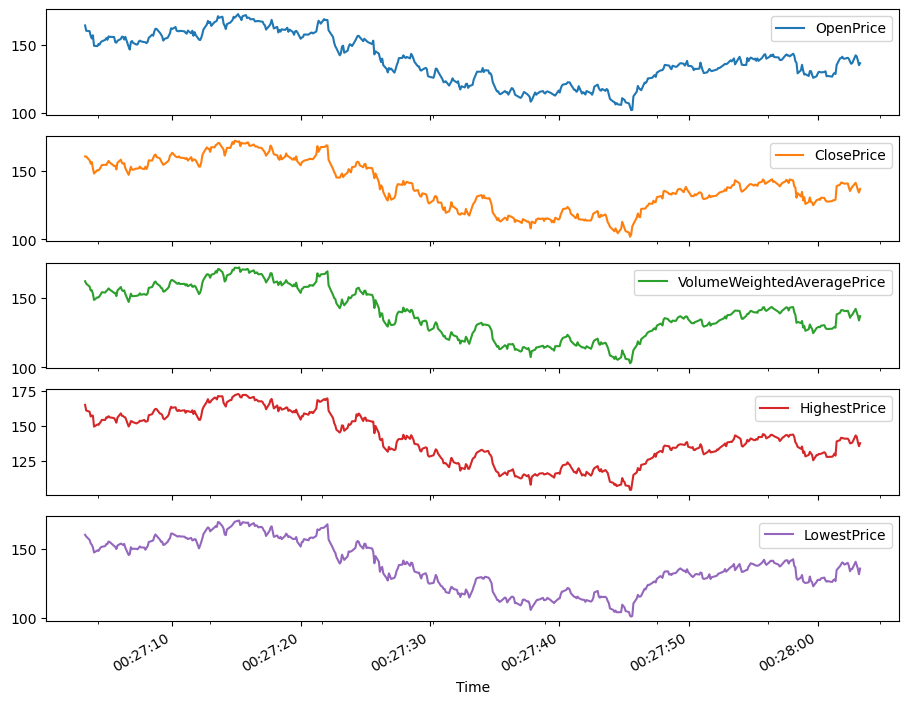

In [21]:
#Visualize a bunch of datasets
plt.figure(figsize=(16, 8)) # resizing the plot
cols = ['OpenPrice', 'ClosePrice', 'VolumeWeightedAveragePrice', 'HighestPrice', 'LowestPrice']
axes = df1[cols].plot(figsize=(11, 9), subplots = True)
plt.show()

In [22]:
#Check for null values
print(df1.isnull().sum())

TradingVolume                 0
VolumeWeightedAveragePrice    0
OpenPrice                     0
ClosePrice                    0
HighestPrice                  0
LowestPrice                   0
NumberOfTransactions          0
dtype: int64


In [ ]:
#Picks data to forecast and makes a column
forecast_out = int(math.ceil(0.05 * len(df1))) # forcasting out 5% of the entire dataset
print(forecast_out)
df1['label'] = df1['ClosePrice'].shift(-forecast_out)

24


In [26]:
#Scale the data down to put all of the columns in the same range
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

scaler = StandardScaler()
X = np.array(df1.drop(['label'], 1))
scaler.fit(X)
X = scaler.transform(X)

C:\Users\brett\AppData\Local\Temp\ipykernel_22104\4065341689.py:6: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = np.array(df1.drop(['label'], 1))


In [27]:
#Choose data to be predicted and trained
X_Predictions = X[-forecast_out:] # data to be predicted
X = X[:-forecast_out] # data to be trained

In [28]:
#Get target values
df1.dropna(inplace=True)
y = np.array(df1['label'])

In [30]:
#Train model wiht 80% of X
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#Linear regression model
#I am only doing this model because it is the only one I really understand the math for
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_confidence = lr.score(X_test, y_test)

In [33]:
#Adding forecasted data to dataset
last_date = df1.index[-1] #getting the lastdate in the dataset
last_unix = last_date.timestamp() #converting it to time in seconds
one_day = 86400 #one day equals 86400 seconds
next_unix = last_unix + one_day # getting the time in seconds for the next day
forecast_set = lr.predict(X_Predictions) # predicting forecast data
df1['Forecast'] = np.nan
for i in forecast_set:
    next_date = datetime.datetime.fromtimestamp(next_unix)
    next_unix += 86400
    df1.loc[next_date] = [np.nan for _ in range(len(df1.columns)-1)]+[i]

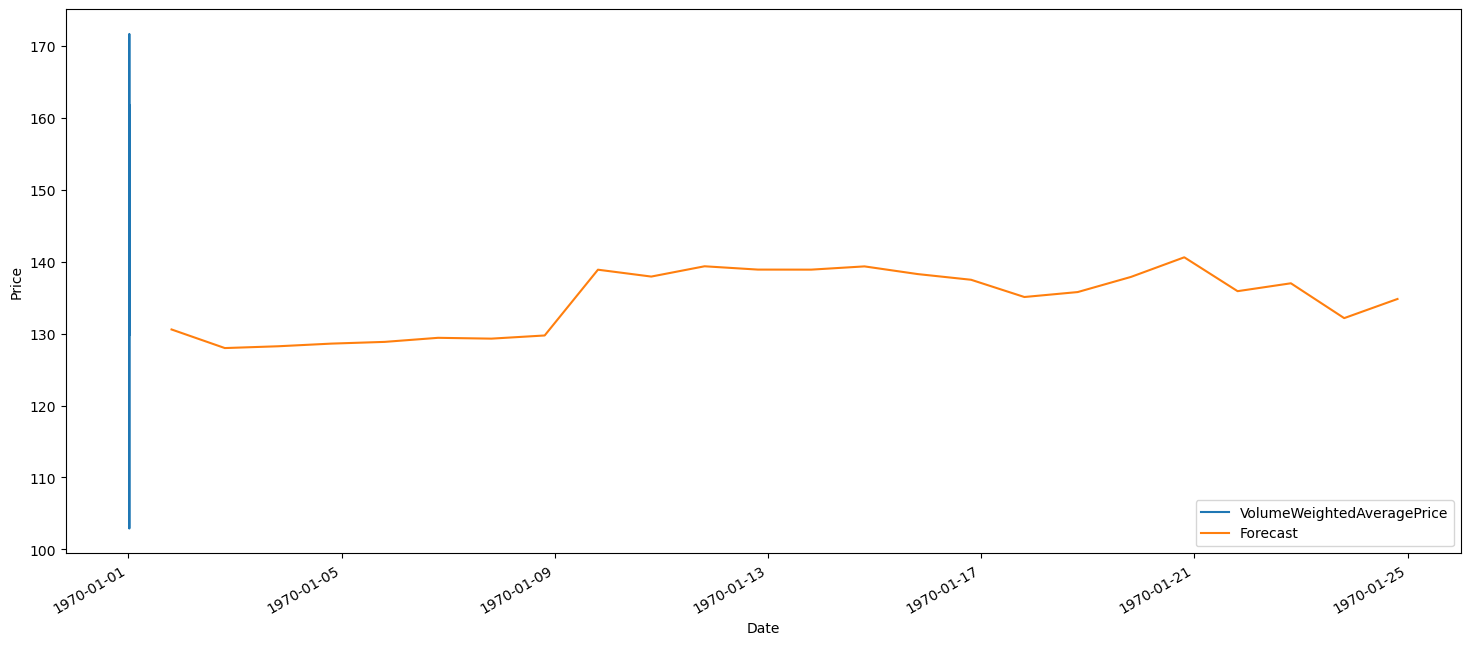

In [35]:
#Visualize forecast data
plt.figure(figsize=(18, 8))
df1['VolumeWeightedAveragePrice'].plot()
df1['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [ ]:
#Issue that was not figured out: datetime format conversion from Unix

#Lessons Learned:
#1. How to call API
#2. How to utilize JSON data format
#3. Basic terminology around stocks
#4. Greater understanding of StandardScaler
#5. How to use forecast to plot